In [15]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import t

df = pd.read_csv('Temp_MN.csv')

# Povprečje in standardni odklon
n = df.shape[0]
mu = df['TEMP'].mean()
sigma = df['TEMP'].std(ddof=1) # <- nepristranska cenilka

# 95% napovedni interval za naslednji dan

zg_meja = mu + 1.96 * sigma * np.sqrt(1 + 1/n)
interval = (sp_meja, zg_meja)
print(f"povprečje: {mu}")
print(f"standardni odklon: {sigma}")
print(f"95% napovedni interval (beli šum): {interval}")

povprečje: 14.090421524663677
standardni odklon: 12.910692967851453
95% napovedni interval (beli šum): (np.float64(-11.22588166407513), np.float64(39.40672471340248))


povprečni šum: 1.804698274707481e-08
opimalni parametri: [12.29655081  7.298332   14.36784202]
sigma: 5.795716846406521
95% napovedni interval (sezonski model): (np.float64(6.2064988255939095), np.float64(28.935894566793415))


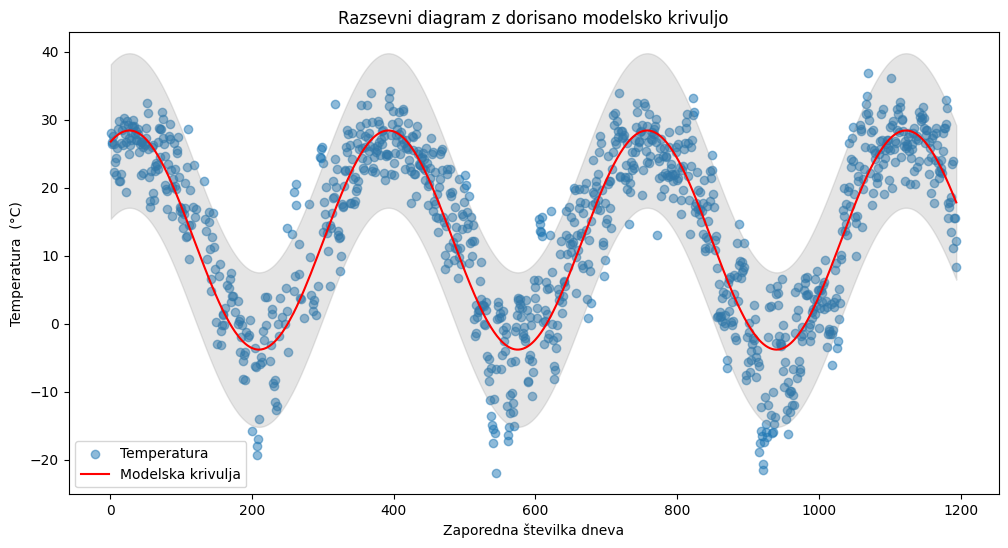

In [16]:
from scipy.optimize import curve_fit
import numpy as np

df = pd.read_csv('Temp_MN.csv')

dan = df['DAN']

def model(t, a0, a1, a2):
    return a0 + a1 * np.sin(2 * np.pi * t / 365.25) + a2 * np.cos(2 * np.pi * t / 365.25)

# Prileganje modela
# popt ... optimalni parametri
# pcov ... kovariančna matrika
popt, _ = curve_fit(model, dan, df['TEMP'])
sumi = df['TEMP'] - model(dan, *popt) # zvezdica 'razpakira' podatke
povprecni_sum = sumi.mean()
sigma = sumi.std(ddof=1)

# Napoved za naslednji dan (zadnji dan + 1)
zadnji_dan = df['DAN'].iloc[-1]
naslednji_dan = zadnji_dan + 1
napoved = model(naslednji_dan, *popt) # zvezdica 'razpakira' podatke


# 95% napovedni interval za naslednji dan

sp_meja1 = napoved + povprecni_sum - 1.96 * sigma * np.sqrt(1 + 1/n)
zg_meja1 = napoved + povprecni_sum + 1.96 * sigma * np.sqrt(1 + 1/n)
interval = (sp_meja1, zg_meja1)
print(f"povprečni šum: {povprecni_sum}")
print(f"opimalni parametri: {popt}")
print(f"sigma: {sigma}")
print(f"95% napovedni interval (sezonski model): {interval}")


# Še vizualizacija
import matplotlib.pyplot as plt

# graf s temperaturami
plt.figure(figsize=(12, 6))
plt.scatter(df['DAN'], df['TEMP'], label='Temperatura', alpha=0.5)

# risanje modelske sinusoide
t = np.linspace(1, 365, 1000)  # Generate points for the curve
plt.plot(df['DAN'], model(dan, *popt), color='red', label='Modelska krivulja')


plt.xlabel('Zaporedna številka dneva')
plt.ylabel('Temperatura  (°C)')
plt.title('Razsevni diagram z dorisano modelsko krivuljo')
plt.legend()

# Napovedni interval v sivem
plt.fill_between(
    df['DAN'],
    model(dan, *popt) + povprecni_sum - 1.96 * sigma * np.sqrt(1 + 1/n),
    model(dan, *popt) + povprecni_sum + 1.96 * sigma * np.sqrt(1 + 1/n),
    color='grey',
    alpha=0.2,
    label='95% Confidence Interval'
)
plt.show()

In [17]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm

# Naloži podatke
df = pd.read_csv('Temp_MN.csv')

# Poskrbi, da so podatki razvrščeni po dnevu
df = df.sort_values('DAN')

# Izračunaj spremembe temperatur med zaporednimi dnevi (delta_T)
df['delta_T'] = df['TEMP'].diff()
df['delta_DAN'] = df['DAN'].diff()

# Uporabi le tiste vrstice, kjer je razlika dneva 1 (zaporedni dnevi)
mask = df['delta_DAN'] == 1
delta_T = df.loc[mask, 'delta_T']
dan = df.loc[mask, 'DAN'] - 1

# Sezonski model za spremembe
def model_sprememb(t, b1, b2):
    return b1 * np.sin(2 * np.pi * t / 365.25) + b2 * np.cos(2 * np.pi * t / 365.25) # CENTRIRANA: konstantni člen = 0

# Prileganje modela
popt, _ = curve_fit(model_sprememb, dan, delta_T)
ostanki = delta_T - model_sprememb(dan, *popt)
n = len(ostanki)
kvadrati_ostankov = np.square(ostanki)
vsota = np.sum(kvadrati_ostankov)
sigma = np.sqrt(vsota / (n - 1)) #nepristranska cenilka za std. odklon
pov = ostanki.mean()


# Napoved za naslednji dan (1195)
naslednji_dan = 1195
delta_pred = model_sprememb(naslednji_dan, *popt)
T_pred = df['TEMP'].iloc[-1] + delta_pred

# 95% napovedni interval za naslednji dan

sp_meja2 = T_pred + pov - 1.96 * sigma * np.sqrt(1 + 1/n)
zg_meja2 = T_pred + pov + 1.96 * sigma * np.sqrt(1 + 1/n)
interval = (sp_meja2, zg_meja2)
print(f"Napoved za dan {naslednji_dan} (dan v letu {naslednji_dan}): {T_pred:.2f}")
print(f"95% napovedni interval (model sprememb): {interval}")
print(f"opimalni parametri: {popt}")
print(sigma)
print(pov)


Napoved za dan 1195 (dan v letu 1195): 8.03
95% napovedni interval (model sprememb): (np.float64(-0.7729431427525695), np.float64(16.760939687318626))
opimalni parametri: [-0.21443296  0.12274411]
4.470846439119658
-0.03685667429759475


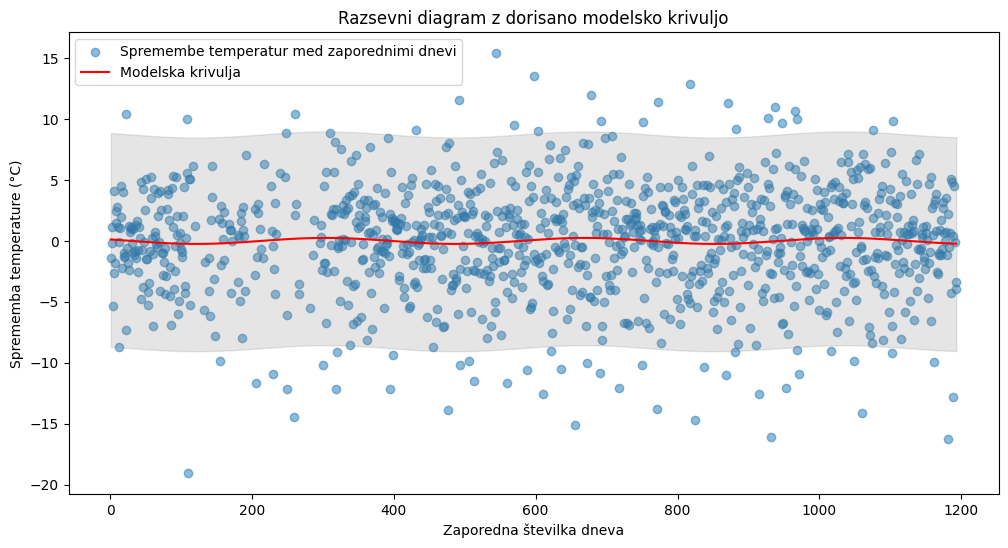

In [18]:
import matplotlib.pyplot as plt

# Razsevni diagram sprememb temperatur
plt.figure(figsize=(12, 6))
plt.scatter(dan, delta_T, label='Spremembe temperatur med zaporednimi dnevi', alpha=0.5)

# Modelska krivulja
t = np.linspace(1, 365, 1000)
plt.plot(dan, model_sprememb(dan, *popt), color='red', label='Modelska krivulja')

# Add labels and legend
plt.xlabel('Zaporedna številka dneva')
plt.ylabel('Sprememba temperature (°C)')
plt.title('Razsevni diagram z dorisano modelsko krivuljo')
plt.legend()
# Osenčeni napovedni interval
plt.fill_between(
    dan,
    model_sprememb(dan, *popt) +  pov - 1.96 * sigma * np.sqrt(1 + 1/n),
    model_sprememb(dan, *popt) +  pov + 1.96 * sigma * np.sqrt(1 + 1/n),
    color='grey',
    alpha=0.2,
    label='95% napovedni interval'
)

plt.show()